# Neoclassical growth model in discrete time: stochastic case

###### First written: February 10, 2020
###### Updated: February 14, 2020

## Key numerical packages
- Gaussian process: `GPyTorch`
- Optimizer: `IPOPT` + `pyipopt`
- Automatic gradient: `PyTorch`

## Introduction

In this notebook, we discuss the following stochastic neoclassical growth model where the social planner maximizes his infinite time horizon utility subject to the budget constraint with full capital depreciation and the stochastic TFP shock

\begin{align}
& \max \mathbb{E}_{0}\left[\sum_{t=0}^{\infty}\beta^{t}\ln \left(C_{t} -\psi N_{t}^{\theta}\right) \right]\\
\text{s.t.} \quad & K_{t+1} + C_{t} \leq A_{t}K_{t}^{\alpha} N_{t}^{1-\alpha} \\
& \ln{A_{t+1}} = \rho \ln{A_{t}} + \epsilon_{t+1}, \quad \epsilon_{t+1} \sim N\left(0, s^{2}\right).
\end{align}

The utility function follows the classical Greenwood–Hercowitz–Huffman preferences (Greenwood et al. (1988)), and the TFP shock follows the AR(1) process.

We know that if the model is deterministic, i.e., $A_{t} = 1, \forall t$, the above neoclassical growth model is well known to have a closed form solution:
\begin{align}
& K_{t+1} = \beta \alpha K_{t}^{\alpha} N_{t}^{1-\alpha} \\
& C_{t} = \left(1- \beta \alpha \right) K_{t}^{\alpha} N_{t}^{1-\alpha}
\end{align}

When we solve the stochastic growth model for its first-order condition, we can derive the following equilibrium condition:
\begin{align}
& \frac{1}{C_{t}} - \beta \alpha \mathbb{E}_{t}\left[\frac{1}{C_{t+1}} A_{t+1} K_{t+1}^{\alpha-1}N_{t+1}^{1-\alpha}\right] = 0
\end{align}

Our aim here is to numerically solve the system of a non-linear equation by the time iteration collocation with Gaussian process regression.

In [1]:
import sys
import warnings
import numpy as np
import torch
import gpytorch
import pyipopt
from smt.sampling_methods import LHS  # Latin Hypercube sampling
# plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
# Use TeX font
rc('font', **{'family': 'sans-serif', 'serif': ['Helvetica']})
rc('text', usetex=True)
plt.rcParams["font.size"] = 15

print(r"PyTorch is version {}".format(torch.__version__))
print(r"GPyTorch is version {}".format(gpytorch.__version__))

np.random.seed(123)
torch.manual_seed(123)

%matplotlib inline

PyTorch is version 1.4.0
GPyTorch is version 1.0.1


where
- `GPyTorch`: modeling the Gaussian process
- `IPOPT` via `pyipopt`: solving the system of non-linear equations.
- `torch`: automatic gradient of (gradient) and Jacobian
- `smt.sampling_methods.LHS`: Latin hypercube sampling

We define economic parameters in following:

In [2]:
A_bar = 1  # The mean of the technology shock
alpha = 0.36  # Capital share in the Cobb-Douglas production function
beta = 0.95  # Discount factor
psi = 0.25  # Coefficient of leisure in the utility function
theta = 1.5  # Elasticity of leisure in the utility function

# AR(1) technology shock
rho = 0.95  # Autocorrelation coefficient
mu = 0  # Mean
s = 0.01  # Standard deviation

## Analytical solutions

As discussed above, the deterministic version of this model has a closed-form solution, in the following way:

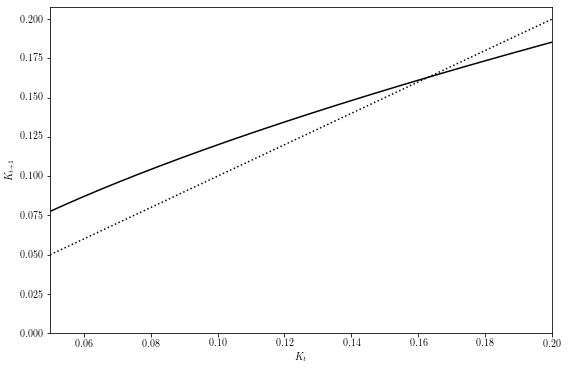

In [3]:
# --------------------------------------------------------------------------- #
# Analytical solution
# --------------------------------------------------------------------------- #
def ls_compute(k, A=A_bar, alpha=alpha, psi=psi, theta=theta):
    """ Return the optimal labor supply """
    return (((1-alpha) * A * k**alpha) / (psi*theta))**(1 / (alpha+theta-1))


def kplus_compute_analytic(
        k, A=A_bar, alpha=alpha, beta=beta, psi=psi, theta=theta):
    """ Analytical solution
    Return the optimal capital stock in the next period """
    _ls = ls_compute(k, A, alpha, psi, theta)
    return alpha * beta * A * k**alpha * _ls**(1-alpha)


def c_compute_analytic(
        k, A=A_bar, alpha=alpha, beta=beta, psi=psi, theta=theta):
    """ Analytical solution
    Return the optimal consumption policy """
    _ls = ls_compute(k, A, alpha, psi, theta)
    return (1 - alpha*beta)*A*k**alpha*_ls**(1-alpha)


# --------------------------------------------------------------------------- #
# Set the exogenous capital domain
# Must include the certainty equivalent steady state
# --------------------------------------------------------------------------- #
kbeg, kend = 0.05, 0.2  # Capital state
abeg, aend = 0.8, 1.2  # AR(1) technology state

# --------------------------------------------------------------------------- #
# Plot the analytical solution
# Control variable: kplus
# --------------------------------------------------------------------------- #
krange = np.linspace(kbeg, kend, 250)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(krange, kplus_compute_analytic(krange), 'k-')
ax.plot(krange, krange, 'k:')
ax.set_xlabel(r"$K_{t}$")
ax.set_ylabel(r"$K_{t+1}$")
ax.set_xlim(kbeg, kend)
ax.set_ylim(0, None)
plt.show()

## Time iteration collocation with the Gaussian process regression

### Discretization
Following Judd (1998), we use the Gauss-Hermite quadrature rule degree 5 to discretize the continuous AR(1) technology shock. The Gauss-Hermite nodes as well as the weights can be defined in the following way:

In [4]:
# --------------------------------------------------------------------------- #
# Gauss-Hermite quadrature
# --------------------------------------------------------------------------- #
# Nodes
x5 = np.sqrt(2) * s * torch.tensor(
    [2.020182870456086, 0.9585724646138185, 0, -0.9585724646138185,
     -2.020182870456086], dtype=torch.float64) + mu

# Weights
omega5 = np.pi**(-1/2) * torch.tensor(
    [0.01995324205904591, 0.3936193231522412, 0.9453087204829419,
     0.3936193231522412, 0.01995324205904591], dtype=torch.float64)

print("GH5 nodes are {}".format(x5))
print("GH5 weights are {}".format(omega5))

GH5 nodes are tensor([ 0.0286,  0.0136,  0.0000, -0.0136, -0.0286], dtype=torch.float64)
GH5 weights are tensor([0.0113, 0.2221, 0.5333, 0.2221, 0.0113], dtype=torch.float64)


### Gaussian process regression

#### Train the Gaussian process regression

Firstly, we train the Gaussian process. We use the RBF kernel. Then we use `Adam` optimizer to find the optimized hyper-parameters of the Gaussian process.

In [5]:
# --------------------------------------------------------------------------- #
# Train the model hyperparameters
# --------------------------------------------------------------------------- #
def TrainGPModel(
        train_X, train_y_kplus, learning_rate, training_iter, print_skip):
    """
    Train the Gaussian process and optimize the model hyperparameters
    train_X.shape == [n, d]
    train_y_kplus.shape == [n]
    """
    # ----------------------------------------------------------------------- #
    # Instantiate and initialize the Gaussian process
    # ----------------------------------------------------------------------- #
    class ExactGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel())

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # Initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    gp_kplus = ExactGPModel(train_X, train_y_kplus, likelihood)

    # Find the optimal model hyperparameters
    gp_kplus.train()
    likelihood.train()

    # Use the Adam optimizer
    optimizer = torch.optim.Adam([
        # Includes GaussianLikelihood parameters
        {'params': gp_kplus.parameters()}, ], lr=learning_rate)

    # Loss for GP - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_kplus)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = gp_kplus(train_X)
        # Calculate the  loss and backprop gradients
        loss = - mll(output, train_y_kplus)
        loss.backward()
        if print_skip != 0 and (i+1) % print_skip == 0:
            print(
                'Iter %d/%d - Loss: %.3f - lengthscale: %.3f - noise: %.3f' % (
                    i + 1, training_iter, loss.item(),
                    gp_kplus.covar_module.base_kernel.lengthscale.item(),
                    gp_kplus.likelihood.noise.item()
                )
            )
        optimizer.step()

    return gp_kplus, likelihood

then test the `TrainGPmodel`. We first prepare the following training sample dataset. Notice that the sampling is done via the Latin Hypercube sampling method.
Note that **the training dataset should be z-scored, but it is not done in this sample**.

Iter 50/1000 - Loss: -1.406 - lengthscale: 2.738 - noise: 0.007
Iter 100/1000 - Loss: -2.618 - lengthscale: 0.264 - noise: 0.000
Iter 150/1000 - Loss: -3.288 - lengthscale: 0.674 - noise: 0.000
Iter 200/1000 - Loss: -3.334 - lengthscale: 1.000 - noise: 0.000
Iter 250/1000 - Loss: -3.348 - lengthscale: 1.250 - noise: 0.000
Iter 300/1000 - Loss: -3.355 - lengthscale: 1.457 - noise: 0.000
Iter 350/1000 - Loss: -3.359 - lengthscale: 1.625 - noise: 0.000
Iter 400/1000 - Loss: -3.361 - lengthscale: 1.761 - noise: 0.000
Iter 450/1000 - Loss: -3.363 - lengthscale: 1.870 - noise: 0.000
Iter 500/1000 - Loss: -3.364 - lengthscale: 1.957 - noise: 0.000
Iter 550/1000 - Loss: -3.365 - lengthscale: 2.028 - noise: 0.000
Iter 600/1000 - Loss: -3.365 - lengthscale: 2.085 - noise: 0.000
Iter 650/1000 - Loss: -3.366 - lengthscale: 2.131 - noise: 0.000
Iter 700/1000 - Loss: -3.366 - lengthscale: 2.168 - noise: 0.000
Iter 750/1000 - Loss: -3.367 - lengthscale: 2.197 - noise: 0.000
Iter 800/1000 - Loss: -3.3

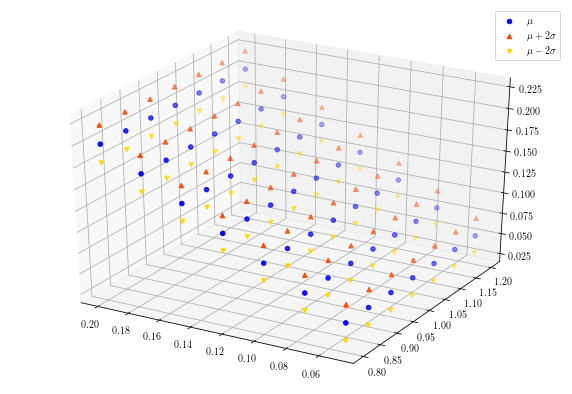

In [6]:
# --------------------------------------------------------------------------- #
# Gaussian process, training and test dataset
# --------------------------------------------------------------------------- #
dim_input = 2  # Dimension of input
num_train = 50  # Number of training samples
num_test = 1000  # Number of test samples

# Training datasets
X_limits = np.array([[kbeg, kend], [abeg, aend]])
X_samping = LHS(xlimits=X_limits)
train_X = torch.tensor(X_samping(num_train), dtype=torch.float64)

train_shape = (num_train, dim_input)

# Test datasets, used to evaluate the approximation quality
test_X = torch.tensor(X_samping(num_test), dtype=torch.float64)
test_shape = (num_test, dim_input)

# Shape check
assert train_X.shape == train_shape, 'Shape is not {}'.format(train_shape)
assert test_X.shape == test_shape, 'Shape is not {}'.format(test_shape)

train_y_kplus = train_X[:, 0]

# --------------------------------------------------------------------------- #
# Train the Gaussian process
# --------------------------------------------------------------------------- #
gp_kplus, likelihood = TrainGPModel(
    train_X, train_y_kplus, learning_rate=0.1, training_iter=1000,
    print_skip=50)

# Get into evaluation (predictive posterior) mode
gp_kplus.eval()
likelihood.eval()

cartesian_size = 7j
k_mgrid, a_mgrid = np.mgrid[
    kbeg:kend:cartesian_size, abeg:aend:cartesian_size]
kplus_mu = np.empty_like(k_mgrid)
kplus_minus2sigma = np.empty_like(k_mgrid)
kplus_plus2sigma = np.empty_like(k_mgrid)

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for k_idx, k in enumerate(k_mgrid[:, 0]):
        for a_idx, a in enumerate(a_mgrid[:, 1]):
            # Capital stock in the next period
            state = torch.tensor([k, a], dtype=torch.float64)[None, :]
            observed_pred = likelihood(gp_kplus(state))
            kplus_mu[k_idx, a_idx] = observed_pred.mean.numpy()
            kplus_minus2sigma[k_idx, a_idx], \
                kplus_plus2sigma[
                    k_idx, a_idx] = observed_pred.confidence_region()

# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(10, 7), subplot_kw={'projection': '3d'})
ax.scatter(k_mgrid, a_mgrid, kplus_mu, c='blue', label=r'$\mu$')
ax.scatter(k_mgrid, a_mgrid, kplus_plus2sigma, c='orangered', marker='^',
           label=r'$\mu+2\sigma$')
ax.scatter(k_mgrid, a_mgrid, kplus_minus2sigma, c='gold', marker='v',
           label=r'$\mu-2\sigma$')
ax.legend(loc='best')
ax.invert_xaxis()
plt.show()

#### Define the equilibrium conditions

The following equilibrium conditions consists of the Euler equation and the resource constraint. We use IPOPT (https://www.coin-or.org/Ipopt/documentation/) to solve the system of non-linear equations. I follow Ferris et al. (2005) to convert a non-linear optimization model to a complementarity format.

Michael C. Ferris, Steven P. Dirkse and Alexander Meeraus, Mathematical Programs with Equilibrium Constraints: Automatic Reformulation and Solution via Constrained Optimization, Frontiers in Applied General Equilibrium Modeling, 2005, DOI: 10.1017/CBO9780511614330.005

We use `torch.autograd.grad` to compute gradient and Jacobian that IPOPT requires. Automatic gradient stabilize the subsequent optimization problems much more than the finite difference method.

In [7]:
# --------------------------------------------------------------------------- #
# Equilibrium conditions
# --------------------------------------------------------------------------- #
def euler(x0, state, gp_kplus, likelihood, alpha, beta, omega5):
    """
    Set of a non-linear equilibrium condition to be solved by IPOPT
    Jacobian is supplied via the automatic gradient of PyTorch
    Hessian is approximated by the IPOPT's limited memory option
    x0: Starting value for the optimization
    state: Current state, state[0]: capital state and state[1]: AR(1) TFP shock
    gp_kplus, likelihood: Gaussian process regression model for the capital
    stock in the next period
    x[0]: Capital stock in the next period
    """
    nvar = 1  # Number of variables

    k, a = state[0], state[1]  # Extract the current state

    # All of plicies are assumed to be non-negative
    x_L = np.ones(nvar) * 0
    x_U = np.ones(nvar) * 1000

    # AR(1) technology shock
    # x5 is the Gauss-Hermite nodes
    aplus = torch.empty(x5.shape, dtype=torch.float64)
    for epsilon_idx, epsilon_plus in enumerate(x5):
        aplus[epsilon_idx] = a**rho * np.exp(epsilon_plus)

    # Current labor supply
    ls = ls_compute(k=k, A=a, alpha=alpha, psi=psi, theta=theta)

    def eval_f(x):
        """ Dummy objective function """
        assert len(x) == nvar
        return 0

    def eval_grad_f(x):
        """ Gradient of the dummy objective function """
        assert len(x) == nvar
        return np.zeros(nvar, dtype=np.float64)

    ncon = nvar  # Number of constraints

    """ Complementarity constraints
    g0: Euler equation wrt. k_{t+1}
    """

    g_L = np.zeros(ncon, dtype=np.float64)
    g_U = g_L

    nnzj = int(nvar * ncon)  # Number of (possibly) non-zeros in Jacobian
    nnzh = int((nvar**2 - nvar) / 2 + nvar)  # Number of non-zeros in Hessian

    def eval_g_tensor(x):
        """
        Represented by PyTorch
        The system of non-linear equilibrium conditions
        x[0]: Capital stock in the next period
        """
        assert len(x) == nvar

        # Consumption today
        con = a * k**alpha * ls**(1-alpha) - x[0]

        # Labor supply tomorrow
        ls_plus = torch.empty(x5.shape, dtype=torch.float64)
        for aplus_idx, aplus_val in enumerate(aplus):
            ls_plus[aplus_idx] = ls_compute(
                k=x[0], A=aplus_val, alpha=alpha, psi=psi, theta=theta)

        # Capital stock tomorrow
        _k_plusplus = []
        for aplus_idx, aplus_val in enumerate(aplus):
            if type(x) is torch.Tensor:  # x is defined as torch.tensor
                state_plus = torch.stack([x[0], aplus_val])[None, :]
            elif type(x) is np.ndarray:  # x is defined as numpy.ndarray
                state_plus = torch.tensor(
                    [x[0], aplus_val], dtype=torch.float64)[None, :]
            else:
                raise TypeError("x shold be either torch.Tensor or np.ndarray")
            pred_mean = likelihood(gp_kplus(state_plus)).mean  # Mean
            _k_plusplus.append(pred_mean)

        k_plusplus = torch.cat(_k_plusplus, dim=0)

        # Consumption tomorrow
        con_plus = aplus * x[0]**alpha * ls_plus**(1-alpha) - k_plusplus

        # ------------------------------------------------------------------- #
        # Euler equation
        # ------------------------------------------------------------------- #
        g0 = 1 / con - beta * alpha * torch.sum(omega5 * (
            1 / con_plus * aplus * x[0]**(alpha-1) * ls_plus**(1-alpha)))

        return [g0]

    def eval_g_numpy(x):
        """ Convert from Tensor to numpy so that IPOPT can handle """
        return np.array(eval_g_tensor(x), dtype=np.float64)

    def eval_jac_g(x, flag):
        """ Numerical approximation of the Jacobian of the system of
        non-linear equilibrium conditions
        Jacobian is computed by the automatic gradient of PyTorch """
        assert len(x) == nvar

        row_idx = np.empty(nnzj, dtype=int)  # Row index
        col_idx = np.empty(nnzj, dtype=int)  # Column index

        # Jacobian matrix structure
        if flag:
            for i in range(ncon):
                for j in range(nvar):
                    row_idx[j + i * nvar] = i
                    col_idx[j + i * nvar] = j

            return (row_idx, col_idx)

        # ------------------------------------------------------------------- #
        # Automatic gradient by PyTorch
        # ------------------------------------------------------------------- #
        else:
            assert len(x) == nvar
            x_grad = torch.tensor(x, requires_grad=True)
            jac = []
            for i in range(ncon):
                grad, = torch.autograd.grad(eval_g_tensor(x_grad)[i], x_grad)
                jac.append(grad)
            return torch.stack(jac).flatten().numpy()

    # ----------------------------------------------------------------------- #
    # Define a NLP model
    # ----------------------------------------------------------------------- #
    pyipopt.set_loglevel(0)  # Let IPOPT quite

    neoclassical = pyipopt.create(
        nvar, x_L, x_U, ncon, g_L, g_U, nnzj, nnzh, eval_f, eval_grad_f,
        eval_g_numpy, eval_jac_g)
    neoclassical.str_option("linear_solver", "ma57")
    neoclassical.str_option("hessian_approximation", "limited-memory")
    # neoclassical.str_option("derivative_test", "first-order")
    neoclassical.int_option("max_iter", 10)
    neoclassical.int_option("print_level", 1)
    xstar, zl, zu, constraint_multipliers, obj, status = neoclassical.solve(x0)

    if status not in [0, 1]:
        warnings.warn(
            "IPOPT fails to solve the system of non-linear equations. "
            "Use the starting value as the solution instead.")
        xstar = x0
    return xstar

#### Time iteration collocation

In [8]:
# --------------------------------------------------------------------------- #
# Time iteration collocation
# --------------------------------------------
def time_iter_gpr(
        num_train, num_test, learning_rate, training_iter, print_skip):
    """
    Time iteration collocation with the Gaussian process regression
    num_train: Number of training examples [num_train, d]
    num_test: Number of test examples [num_test, d]
    learning_rate: Learning rate in the hyperparameters optimization
    training_iter: Number of training iterations
    print_skip: Print skip in the hyperparameters optimization
    """
    # ----------------------------------------------------------------------- #
    # General settings of time iteration
    # ----------------------------------------------------------------------- #
    num_iter = 500  # Number of time iterations
    epsilons = []  # Track the approximation error
    epsilon_tol = 1e-5  # Convergence tolrance

    # ----------------------------------------------------------------------- #
    # Generate a training dataset, Latin Hypercube sampling
    # ----------------------------------------------------------------------- #
    X_limits = np.array([[kbeg, kend], [abeg, aend]])
    X_samping = LHS(xlimits=X_limits)

    # Training datasets
    train_X = torch.tensor(X_samping(num_train), dtype=torch.float64)

    # Test datasets
    test_X = torch.tensor(X_samping(num_test), dtype=torch.float64)

    # sys.exit(0)
    # ----------------------------------------------------------------------- #
    # Initialize outputs
    # ----------------------------------------------------------------------- #
    train_y_kplus = train_X[:, 0]

    # Shape checks
    assert train_X.shape == (num_train, 2), 'Shape is not (num_train, 2)'
    assert train_y_kplus.shape == (num_train, ), 'Shape is not (num_train, )'
    print(r"Shape of the training dataset is {}".format(train_X.shape))
    print(r"Shape of the test dataset is {}".format(test_X.shape))

    # sys.exit(0)
    # ----------------------------------------------------------------------- #
    # Instantiate and train the Gaussian processes
    # ----------------------------------------------------------------------- #
    gp_kplus, likelihood = TrainGPModel(
        train_X, train_y_kplus, learning_rate=learning_rate,
        training_iter=training_iter, print_skip=print_skip)

    # sys.exit(0)
    # ----------------------------------------------------------------------- #
    # Time iteration collocation with the Gaussian process regression
    # ----------------------------------------------------------------------- #
    for n in range(1, num_iter+1):

        # Get into evaluation (predictive posterior) mode
        gp_kplus.eval()
        likelihood.eval()

        # Starting value retliving from the previous optimization
        x0 = train_y_kplus.numpy()[:, None]

        # Track the optimal policies
        train_y_kplus = np.empty(num_train, dtype=np.float64)

        for idx, state in enumerate(train_X.numpy()):
            # For each state, solve the system of non-linear equations
            xstar = euler(
                x0[idx], state, gp_kplus, likelihood, alpha, beta, omega5)
            # sys.exit(0)
            # Track the optimal policies
            train_y_kplus[idx] = xstar

        # ------------------------------------------------------------------- #
        # Train the Gaussian process with the optimal policy
        # ------------------------------------------------------------------- #
        # Training data
        train_y_kplus = torch.tensor(train_y_kplus, dtype=torch.float64)

        # Training
        gp_kplus_updated, likelihood_updated = TrainGPModel(
            train_X, train_y_kplus, learning_rate=learning_rate,
            training_iter=training_iter, print_skip=print_skip)
        # sys.exit(0)

        # ------------------------------------------------------------------- #
        # Approximation error analysis
        # Update the policy functions for the next iteration
        # ------------------------------------------------------------------- #
        # Switch to the evaluation mode
        gp_kplus.eval()
        gp_kplus_updated.eval()
        likelihood.eval()
        likelihood_updated.eval()

        # Make predictions by feeding model through likelihood
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred_kplus = likelihood(gp_kplus(test_X))
            pred_update_kplus = likelihood_updated(gp_kplus_updated(test_X))

            epsilon = np.max(np.abs(
                pred_kplus.mean.numpy() - pred_update_kplus.mean.numpy()))
        epsilons.append(epsilon)  # Track the history of epsilon

        if n % 1 == 0:
            print('Iteration: {}, Approximation error: {:.3e}'.format(
                n, epsilons[-1]))

        if epsilons[-1] < epsilon_tol:
            # Terminate the time iteration and save the optimal surrogates
            gp_kplus_star = gp_kplus_updated
            likelihood_star = likelihood_updated
            print("Time iteration collocation is terminated successfuly with "
                  "{} iterations".format(n))
            break  # Terminate the iteration

        else:
            # Update the GP with the surrogates
            gp_kplus = gp_kplus_updated
            likelihood = likelihood_updated

    return epsilons, gp_kplus_star, likelihood_star

## Optimal policy function

### Convergence
Firstly we compute for the optimal policy functions.

In [9]:
# %timeit
# --------------------------------------------------------------------------- #
# Compute the optimal policy functions
# --------------------------------------------------------------------------- #
epsilons, gp_kplus_star, likelihood_star = time_iter_gpr(
    num_train=30, num_test=1000, learning_rate=0.05, training_iter=500,
    print_skip=0)

Shape of the training dataset is torch.Size([30, 2])
Shape of the test dataset is torch.Size([1000, 2])
Iteration: 1, Approximation error: 5.379e-02
Iteration: 2, Approximation error: 1.309e-02
Iteration: 3, Approximation error: 2.823e-03
Iteration: 4, Approximation error: 5.723e-04
Iteration: 5, Approximation error: 1.111e-04
Iteration: 6, Approximation error: 2.606e-05
Iteration: 7, Approximation error: 6.609e-06
Time iteration collocation is terminated successfuly with 7 iterations


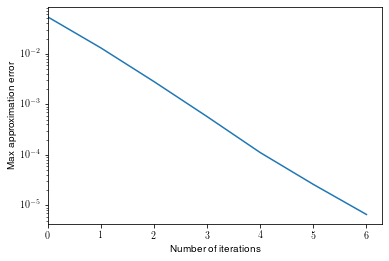

In [10]:
# --------------------------------------------------------------------------- #
# Plot an approximation error
# --------------------------------------------------------------------------- #
plt.plot(range(len(epsilons)), epsilons)
plt.yscale('log')
plt.xlabel("Number of iterations")
plt.ylabel("Max approximation error")
plt.xlim([0, None])
plt.show()

### Policy functions
Plot the policy functions.

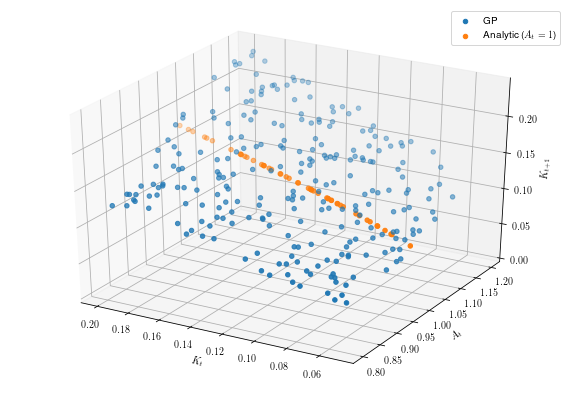

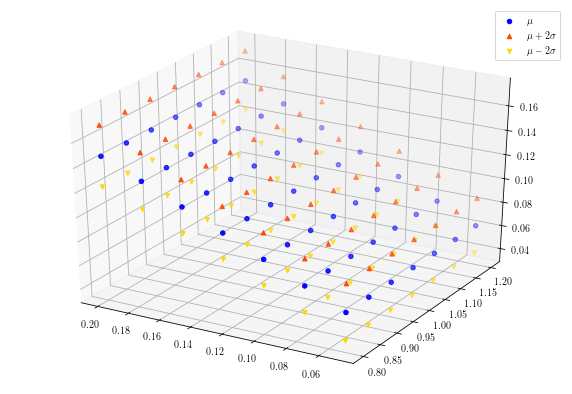

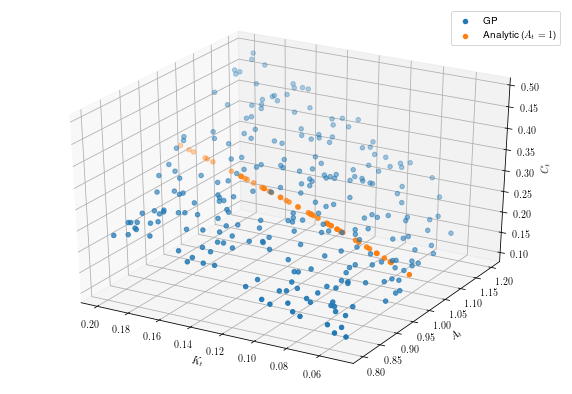

In [11]:
# --------------------------------------------------------------------------- #
# Plot approximated policy functions
# --------------------------------------------------------------------------- #
gridplt = X_samping(250)

# Analytical solution when A = 1
gridplt_analytic = np.random.uniform([kbeg, 1], [kend, 1], (50, dim_input))

# Capital stock ------------------------------------------------------------- #
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    stateplus = torch.tensor(gridplt, dtype=torch.float64)
    observed_pred = likelihood_star(gp_kplus_star(stateplus))
    kplus_star = observed_pred.mean.numpy()

kplus_analytic = kplus_compute_analytic(gridplt_analytic[:, 0])

fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': '3d'})
ax.scatter(
    gridplt[:, 0], gridplt[:, 1], kplus_star.ravel(), 'o', label='GP')
ax.scatter(
    gridplt_analytic[:, 0], gridplt_analytic[:, 1], kplus_analytic, 'o',
    label='Analytic ($A_{t}=1$)')
ax.set_xlabel(r"$K_t$")
ax.set_ylabel(r"$A_t$")
ax.set_zlabel(r"$K_{t+1}$")
ax.set_zlim([0, None])
ax.invert_xaxis()
ax.legend(loc='best')
plt.show()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for k_idx, k in enumerate(k_mgrid[:, 0]):
        for a_idx, a in enumerate(a_mgrid[:, 1]):
            # Capital stock in the next period
            state = torch.tensor([k, a], dtype=torch.float64)[None, :]
            pred = likelihood_star(gp_kplus_star(state))
            kplus_mu[k_idx, a_idx] = pred.mean.numpy()
            kplus_minus2sigma[k_idx, a_idx], kplus_plus2sigma[k_idx, a_idx] = \
                pred.confidence_region()

# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(10, 7), subplot_kw={'projection': '3d'})
ax.scatter(k_mgrid, a_mgrid, kplus_mu, c='blue', label=r'$\mu$')
ax.scatter(k_mgrid, a_mgrid, kplus_plus2sigma, c='orangered', marker='^',
           label=r'$\mu+2\sigma$')
ax.scatter(k_mgrid, a_mgrid, kplus_minus2sigma, c='gold', marker='v',
           label=r'$\mu-2\sigma$')
ax.legend(loc='best')
ax.invert_xaxis()
plt.show()

# Labor supply -------------------------------------------------------------- #
ls_star = ls_compute(
    gridplt[:, 0], gridplt[:, 1], alpha=alpha, psi=psi, theta=theta)

# Consumption --------------------------------------------------------------- #
c_star = gridplt[:, 1] * gridplt[:, 0]**alpha * ls_star**(1-alpha) - kplus_star

c_star_analytic = c_compute_analytic(
    gridplt_analytic[:, 0], A=gridplt_analytic[:, 1], alpha=alpha, beta=beta,
    psi=psi, theta=theta)

fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': '3d'})
ax.scatter(
    gridplt[:, 0], gridplt[:, 1], c_star, 'o', label='GP')
ax.scatter(
    gridplt_analytic[:, 0], gridplt_analytic[:, 1], c_star_analytic, 'o',
    label='Analytic ($A_{t}=1$)')
ax.set_xlabel(r"$K_t$")
ax.set_ylabel(r"$A_t$")
ax.set_zlabel(r"$C_{t}$")
ax.invert_xaxis()
ax.legend(loc='best')
plt.show()

### Mean and the standard deviation

We plot the predictive mean ($\mu$) as well as the point-wise predictive mean $\pm$ the two standard deviations ($\sigma$) of the approximated two policy functions. We train the model with randomly generated 25 training samples to construct the surrogates. As observed above, we can predict the optimal capital stock in the next period with a relatively big confidence interval. We need to train the model with:
- the larger amount of training examples
- the z-scored training outputs
to achieve a better-fit, but I leave this for the future notebook.